### Avaliação Fora da Amostra (Simulação de Produção)

---



Nessa etapa o objetivo é avaliar o modelo final de fraude em um conjunto de dados nunca utilizado no treinamento, simulando um cenário real de produção e analisando o impacto de negócio da escolha do threshold.



In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: (36030, 30)
y_test: (36030,)


Após consolidar o modelo final, salvei todo o pipeline — incluindo pré-processamento, PCA e modelo — em um único artefato com joblib, garantindo reprodutibilidade, versionamento e facilidade de deploy

---



In [3]:
import joblib

pipeline_final = joblib.load("fraud_model_pipeline.joblib")

###  Probabilidades previstas (cenário real)

---



In [4]:
y_prob = pipeline_final.predict_proba(X_test)[:, 1]

print("Probabilidades geradas com sucesso")

Probabilidades geradas com sucesso


### Avaliação global – ROC-AUC fora da amostra

---



In [5]:
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC fora da amostra: {roc_auc:.4f}")

ROC-AUC fora da amostra: 0.9780


### Curva Precision-Recall

---



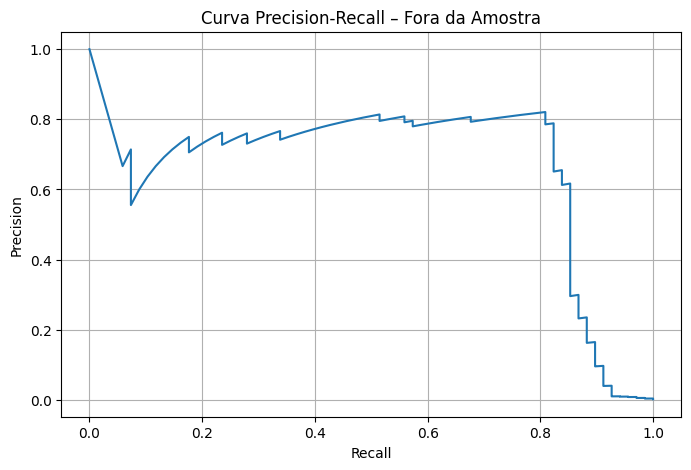

In [6]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall – Fora da Amostra')
plt.grid(True)
plt.show()

In [8]:
y_pred_opt = (y_prob >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35962
         1.0       0.82      0.81      0.81        68

    accuracy                           1.00     36030
   macro avg       0.91      0.90      0.91     36030
weighted avg       1.00      1.00      1.00     36030



### Escolha do threshold ótimo

---



In [7]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
print(f"Threshold ótimo (F1): {best_threshold:.3f}")

Threshold ótimo (F1): 1.000


### Avaliação com threshold ótimo  e matriz de confusão – cenário operacional

---



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     35962
         1.0       0.82      0.81      0.81        68

    accuracy                           1.00     36030
   macro avg       0.91      0.90      0.91     36030
weighted avg       1.00      1.00      1.00     36030



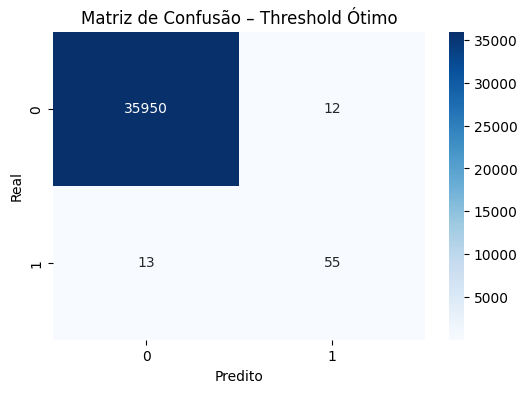

In [9]:
y_pred_opt = (y_prob >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_opt))


cm = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão – Threshold Ótimo')
plt.show()

### Análise de impacto de negócio

---



In [10]:
total_transacoes = len(y_test)
fraudes_reais = y_test.sum()
fraudes_detectadas = cm[1,1]
falsos_positivos = cm[0,1]

print(f"Total de transações avaliadas: {total_transacoes}")
print(f"Fraudes reais: {fraudes_reais}")
print(f"Fraudes detectadas: {fraudes_detectadas}")
print(f"Fraudes perdidas (FN): {cm[1,0]}")
print(f"Clientes impactados indevidamente (FP): {falsos_positivos}")

Total de transações avaliadas: 36030
Fraudes reais: 68.0
Fraudes detectadas: 55
Fraudes perdidas (FN): 13
Clientes impactados indevidamente (FP): 12


 Modelo mantém capacidade de generalização fora da amostra
,Threshold ajustado conforme objetivo de negócio
,Trade-off entre recall e precisão explicitamente controlado